# State Schema

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions

## Goals

Now, we want to continue with getting a deeper understanding  of `State`.

In [2]:
import os

from dotenv import load_dotenv

load_dotenv()

True

# Schema

In order to define input schemas to nodes, we define [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state). This defines the structure and types of data that graph uses:
* All nodes use this schema to communicate with one another.

To define state schema, on may use various libraries, including:
* TypedDict, and
* pydantic

### TypedDict

As it has been shown, one may use `TypedDict` to define a dictionary containing keys and values. The only different it has (with the normal dictation) is that it allows to define the data type of each value.  

In [4]:
from typing_extensions import TypedDict
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    taste: Literal['good', 'bad']

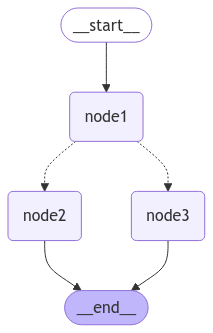

In [8]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node1(state: TypedDictState):
    print("----Node 1----")
    return {'name': 'The tast of the ' + state['name'] + " is "}

def node2(state: TypedDictState):
    print("----Node 2----")
    return {'taste': 'good'}

def node3(state: TypedDictState):
    print("----Node 2----")
    return {'taste': 'bad'}

def decide(state) -> Literal["node2", "node3"]:
        
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:
        return "node2"
    
    return "node3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

# Logic
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({'name': 'kapsalon'})

----Node 1----
----Node 2----


{'name': 'The tast of the kapsalon is ', 'taste': 'bad'}

### Pydantic

`TypedDict` only provides type instruction, but at runtime it does not enforce types. Thus, if we use a wrong data type for a value, it does not give any error.

To ensure we always provide the correct data type for any value, we can use [Pydantic](https://docs.pydantic.dev/latest/api/base_model/):
* it can perform validation to check if data has the specified types and constraints at runtime.

In [10]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    taste: str
        
    @field_validator('taste')
    @classmethod
    def validate_taste(cls, value):
        # to ensure if the taste is 'good' or 'bad'
        if value not in ['good', 'bad']:
            raise ValueError("The taste must be either 'good' or 'bad'")
        return value
    
try:
    state = PydanticState(name="kapsalon", taste='not good')
except ValidationError as e:
    print("Validation Error: ", e)
        

Validation Error:  1 validation error for PydanticState
taste
  Value error, The taste must be either 'good' or 'bad' [type=value_error, input_value='not good', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error
